In [1]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
from scipy import stats
#For some Statistics
from scipy.stats import norm, skew
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.linear_model import LogisticRegression,Lasso,Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_auc_score,confusion_matrix,precision_score,classification_report,make_scorer
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
from sklearn.cross_validation import cross_val_predict
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
data_main = pd.read_csv("./../data/train_LZdllcl.xls",index_col=0)    
df_main_test = pd.read_csv('./../data/test_2umaH9m.xls',index_col=0)
print(data_main.shape)
print(df_main_test.shape)

(54808, 13)
(23490, 12)


In [3]:
data_main.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
data_main.isnull().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [5]:
for i in data_main.columns:
    print(data_main[i].value_counts())
    print('----------------------------------------------------------')


Sales & Marketing    16840
Operations           11348
Procurement           7138
Technology            7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64
----------------------------------------------------------
region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: 

In [6]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54808 entries, 65438 to 51526
Data columns (total 13 columns):
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 5.9+ MB


50140
4668


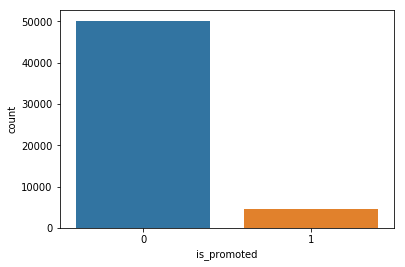

In [7]:
sns.countplot(data_main['is_promoted'])
total=data_main['is_promoted'].count()
zero=data_main[data_main['is_promoted']==0].shape[0]
one=data_main[data_main['is_promoted']==1].shape[0]
percent_zero=zero/total
percent_one=one/total
print(zero)
print(one)

# Encoding

In [3]:
from sklearn.preprocessing import Imputer,LabelEncoder,OneHotEncoder,LabelBinarizer

In [4]:

def encodingCol(df,df_test, col_name,mode):
    for feature in col_name:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        df_test[feature] = le.transform(df_test[feature])         
    
    for feature in col_name:
        enc = LabelBinarizer()
        enc.fit(df[feature])
        abc=enc.transform(df[feature])
        abc1=enc.transform(df_test[feature])
        for i in range(abc.shape[1]):
            s=feature+str(i)
            df[s]=abc[:,i]
            df[s]=df[s].astype(np.int64)
        del df[feature]
        for i in range(abc1.shape[1]):
            s=feature+str(i)
            df_test[s]=abc1[:,i]
            df_test[s]=df_test[s].astype(np.int64)
        del df_test[feature]
    return df,df_test
one_hot_col=['department','region','gender','recruitment_channel']#'education'
print(data_main.shape)
df,df_test=encodingCol(data_main.copy(),df_main_test.copy(),one_hot_col,'train')
print(df.shape)
print(df_test.shape)
print(data_main.shape)

(54808, 13)
(54808, 56)
(23490, 55)
(54808, 13)


# education filling missing value with xgb

In [5]:
###education
def processedu(df,df_test,dlist,dtestlist):
    ##train
    dict1={'Master\'s & above':3,'Bachelor\'s':2,'Below Secondary':1}
    df['education']=df['education'].apply(lambda x : dict1[x] if x in dict1  else  99)
    df['education']=df['education'].astype(np.int64)  
    X=df[df['education'] != 99].copy().drop(labels=dlist,axis=1)
    y=df[df['education'] != 99]['education'].copy()
    regressor = XGBClassifier()
    regressor.fit(X, y)
    X2=df[df['education'] == 99].copy().drop(labels=dlist,axis=1)
    y_pred=regressor.predict(X2)
    df_sub = pd.DataFrame(y_pred,index=X2.index,columns=['education'])
    df_j=df.join(df_sub,how='left', rsuffix='_other')
    df_j['education_other'].fillna(0,inplace=True)
    df_j['education']=df_j['education']+df_j['education_other']
    df_j['education']=df_j['education'].apply(lambda x: x if x<99 else x-99)
    del df_j['education_other']
    
    ##test
    df_test['education']=df_test['education'].apply(lambda x : dict1[x] if x in dict1  else  99)
    df_test['education']=df_test['education'].astype(np.int64)  
    X2test=df_test[df_test['education'] == 99].copy().drop(labels=dtestlist,axis=1)
    y_pred_test=regressor.predict(X2test)
    df_sub_test = pd.DataFrame(y_pred_test,index=X2test.index,columns=['education'])
    df_j_test=df_test.join(df_sub_test,how='left', rsuffix='_other')
    df_j_test['education_other'].fillna(0,inplace=True)
    df_j_test['education']=df_j_test['education']+df_j_test['education_other']
    df_j_test['education']=df_j_test['education'].apply(lambda x: x if x<99 else x-99)
    del df_j_test['education_other']
    
    enc = LabelBinarizer()
    enc.fit(df_j['education'])
    abc=enc.transform(df_j['education'])
    abc1=enc.transform(df_j_test['education'])
    for i in range(abc.shape[1]):
        s='education'+str(i)
        df_j[s]=abc[:,i]
        df_j[s]=df_j[s].astype(np.int64)
    del df_j['education']
    for i in range(abc1.shape[1]):
        s='education'+str(i)
        df_j_test[s]=abc1[:,i]
        df_j_test[s]=df_j_test[s].astype(np.int64)
    del df_j_test['education']
     
    
    return df_j,df_j_test
df_edu,df_edu_test=processedu(df.copy(),df_test.copy(),['previous_year_rating','is_promoted','education'],['previous_year_rating','education'])
print(df_edu.shape)
print(df_edu_test.shape)

(54808, 58)
(23490, 57)


# pre processing previous year rating

In [6]:
def proccesspyr(df,df_test,dlist,dtestlist):
    df['previous_year_rating'].fillna(99,inplace=True)
    X=df[df['previous_year_rating']!= 99].copy().drop(labels=dlist,axis=1)
    y=df[df['previous_year_rating']!= 99]['previous_year_rating'].copy()
    regressor = XGBClassifier()
    regressor.fit(X, y)
    X2=df[df['previous_year_rating']== 99].copy().drop(labels=dlist,axis=1)
    y_pred = regressor.predict(X2)
    df_sub = pd.DataFrame(y_pred,index=X2.index,columns=['previous_year_rating'])
    df_pyr=df.join(df_sub,how='left', rsuffix='_other')
    df_pyr['previous_year_rating_other'].fillna(0,inplace=True)
    df_pyr['previous_year_rating']=df_pyr['previous_year_rating']+df_pyr['previous_year_rating_other']
    df_pyr['previous_year_rating']=df_pyr['previous_year_rating'].apply(lambda x: x if x<99 else x-99)
    del df_pyr['previous_year_rating_other']
    
    df_test['previous_year_rating'].fillna(99,inplace=True)
    X=df_test[df_test['previous_year_rating']!= 99].copy().drop(labels=dtestlist,axis=1)
    y=df_test[df_test['previous_year_rating']!= 99]['previous_year_rating'].copy()
    X2_test=df_test[df_test['previous_year_rating']== 99].copy().drop(labels=dtestlist,axis=1)
    y_pred_test = regressor.predict(X2_test)
    df_sub_test = pd.DataFrame(y_pred_test,index=X2_test.index,columns=['previous_year_rating'])
    df_pyr_test=df_test.join(df_sub_test,how='left', rsuffix='_other')
    df_pyr_test['previous_year_rating_other'].fillna(0,inplace=True)
    df_pyr_test['previous_year_rating']=df_pyr_test['previous_year_rating']+df_pyr_test['previous_year_rating_other']
    df_pyr_test['previous_year_rating']=df_pyr_test['previous_year_rating'].apply(lambda x: x if x<99 else x-99)
    del df_pyr_test['previous_year_rating_other']
    
    
    
    
    
    return df_pyr,df_pyr_test
df_pyr,df_pyr_test=proccesspyr(df_edu.copy(),df_edu_test.copy(),['previous_year_rating','is_promoted'],['previous_year_rating'])

print(df_pyr.shape)
print(df_pyr_test.shape)

(54808, 58)
(23490, 57)


In [13]:
print(data_main.shape)

(54808, 13)


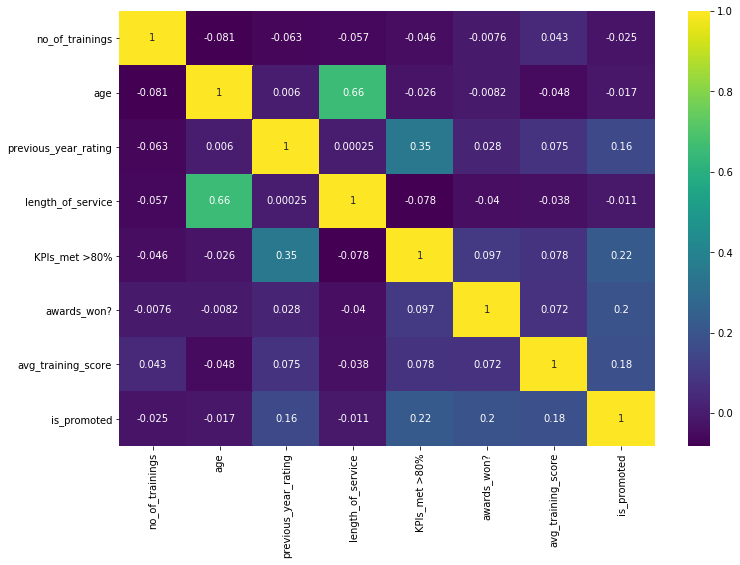

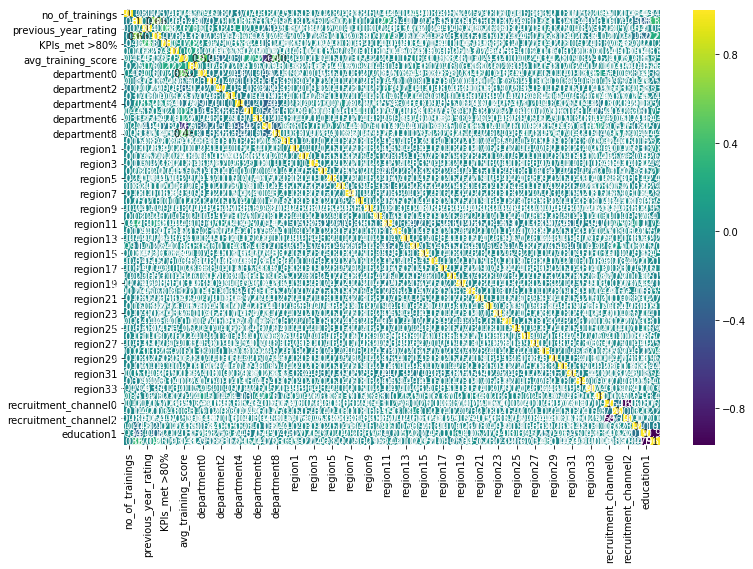

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(data_main.corr(), cmap='viridis',annot=True)
plt.figure(figsize=(12,8))
sns.heatmap(df_pyr.corr(), cmap='viridis',annot=True)

In [15]:
data_main.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'is_promoted'],
      dtype='object')

is_promoted            0     1
department                    
Analytics           4840   512
Finance             2330   206
HR                  2282   136
Legal                986    53
Operations         10325  1023
Procurement         6450   688
R&D                  930    69
Sales & Marketing  15627  1213
Technology          6370   768
is_promoted      0    1
region                 
region_1       552   58
region_10      597   51
region_11     1241   74
region_12      467   33
region_13     2418  230
region_14      765   62
region_15     2586  222
region_16     1363  102
region_17      687  109
region_18       30    1
region_19      821   53
region_2     11354  989
region_20      801   49
region_21      393   18
region_22     5694  734
region_23     1038  137
region_24      490   18
region_25      716  103
region_26     2117  143
region_27     1528  131
region_28     1164  154
region_29      951   43
region_3       309   37
region_30      598   59
region_31     1825  110
region_32  

ValueError: Duplicated level name: "is_promoted", assigned to level 1, is already used for level 0.

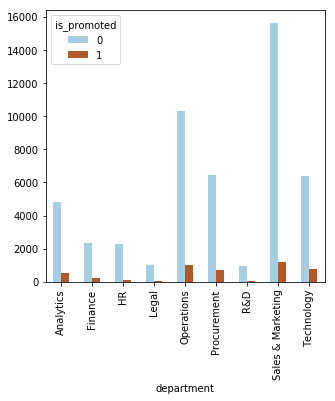

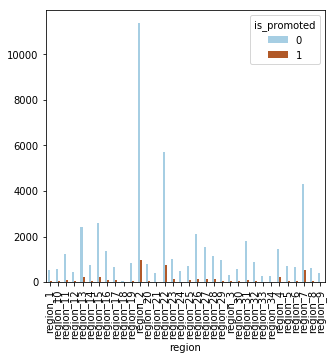

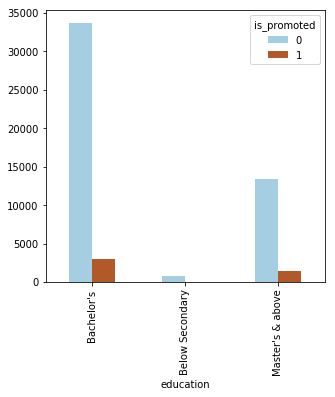

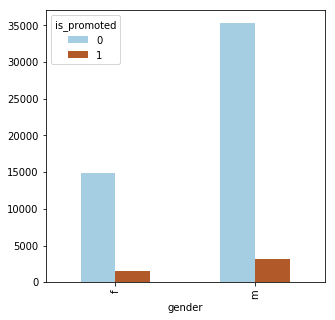

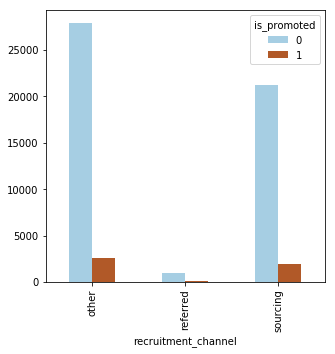

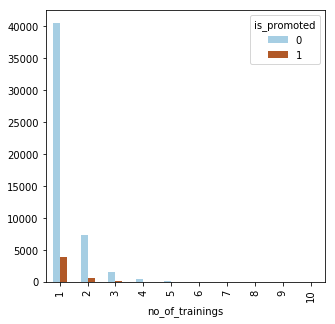

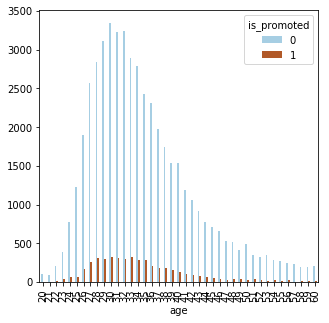

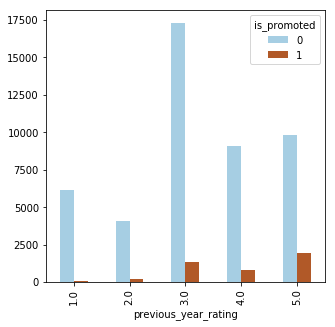

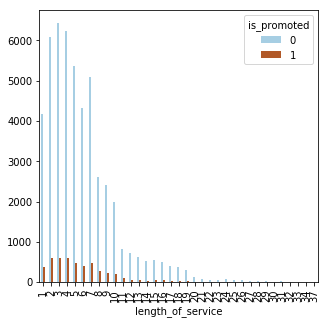

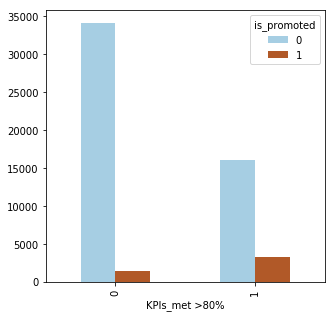

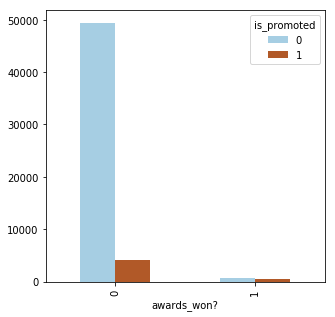

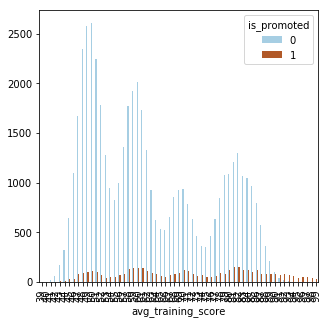

In [16]:
for i in data_main.columns:
    crosstab = pd.crosstab(index=data_main[i], columns=data_main['is_promoted'])
    crosstab.plot(kind="bar", figsize=(5,5), stacked=False, colormap='Paired')
    print(crosstab)

In [7]:
X_pca=df_pyr.copy().drop('is_promoted',axis=1)
y=df_pyr['is_promoted'].copy()

# PCA on data

In [8]:

from sklearn.decomposition import PCA
pca = PCA(n_components=35)
pca.fit(X_pca)
X = pca.transform(X_pca)

# Build model with Logistic Regression with parameter tuning

In [9]:
#logistic regression
logistic_regressor = LogisticRegression(n_jobs=-1,solver='lbfgs')
pipeline = Pipeline(steps=[('add_poly_features', PolynomialFeatures(2)),('logistic_regression', logistic_regressor)])
pipeline.fit(X,y)

y_pred_train_LR = cross_val_predict(pipeline,X,y,cv=5)
accuracy = accuracy_score(y, y_pred_train_LR)
print(classification_report(y, y_pred_train_LR))
print("Accuracy Train: %.2f%%" % (accuracy * 100.0))
print(f1_score(y, y_pred_train_LR, average='weighted'))
print(confusion_matrix(y, y_pred_train_LR))#81,26,40,292,3444

             precision    recall  f1-score   support

          0       0.94      1.00      0.97     50140
          1       0.88      0.30      0.44      4668

avg / total       0.93      0.94      0.92     54808

Accuracy Train: 93.66%
0.9218969579507126
[[49943   197]
 [ 3279  1389]]


# Random Forest with Parameter tuning

In [9]:
rf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=9, verbose=0, warm_start=False)
rf.fit(X,y)
preds_rf = cross_val_predict(rf,X,y,cv=5)
print(classification_report(y, preds_rf))
print("ACCURACY Train::", accuracy_score(preds_rf, y))
print(f1_score(y, preds_rf, average='weighted'))
print(confusion_matrix(y, preds_rf))#79,31,45,385,3199
rf

             precision    recall  f1-score   support

          0       0.94      1.00      0.97     50140
          1       0.97      0.30      0.46      4668

avg / total       0.94      0.94      0.92     54808

ACCURACY Train:: 0.9394431469858415
0.9243052680298325
[[50100    40]
 [ 3279  1389]]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=9, verbose=0, warm_start=False)

In [25]:
parameter = {'n_estimators': [100],
             'max_features': ['log2', 'sqrt', 'auto'],
             'criterion': ['entropy', 'gini'],
             'max_depth': [6,8,10,12],
             'min_samples_split': [2,4,6],
             'min_samples_leaf': [2,4,6],
             'bootstrap': [True],
             'oob_score': [True]
            }

def gridfunc(classifier, parameter, X_train, y_train):      
    clf = classifier
    np.random.seed(9)
    parameters = parameter
    acc_scorer = make_scorer(accuracy_score) #what kind of performance measure you want
   
   # Run the grid search
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer) #find the best parameter out of all by comparing the accuracy score of all
    grid_obj = grid_obj.fit(X_train, y_train) #input to the next function
   
    return grid_obj
#task find the results for the given params
classifier = RandomForestClassifier(random_state=9,n_jobs=-1)
grid = gridfunc(classifier, parameter, X, y)
clf = grid.best_estimator_
print(clf)
clf.fit(X,y)

y_pred = cross_val_predict(rf,X,y,cv=5)
accuracy_clf_1 = accuracy_score(y, y_pred)
auc_roc1 = roc_auc_score(y, y_pred)
print("Accuracy score of the model with min sample leaf 6 is: {}".format(accuracy_clf_1))
print("roc_auc_score of the model1 is: {}".format(auc_roc1))
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=9, verbose=0, warm_start=False)
Accuracy score of the model with min sample leaf 6 is: 0.9346445774339512
roc_auc_score of the model1 is: 0.6544999964110773
             precision    recall  f1-score   support

          0       0.94      0.99      0.97     50140
          1       0.79      0.32      0.45      4668

avg / total       0.93      0.93      0.92     54808

[[49747   393]
 [ 3189  1479]]


# LGB Classifier

In [11]:
import lightgbm as lgb
gbm = lgb.LGBMClassifier(base_score=0.5, booster='rf', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1,eval_metric='auc')
gbm.fit(X_rfe,y)
y_pred_train_xgb = cross_val_predict(gbm,X_rfe,y,cv=5)
accuracy = accuracy_score(y, y_pred_train_xgb)
print(classification_report(y, y_pred_train_xgb))
print("Accuracy Train: %.2f%%" % (accuracy * 100.0))
print(f1_score(y, y_pred_train_xgb, average='weighted'))
print(confusion_matrix(y, y_pred_train_xgb))# 0.92      0.33      0.49

             precision    recall  f1-score   support

          0       0.94      1.00      0.97     50140
          1       0.94      0.34      0.50      4668

avg / total       0.94      0.94      0.93     54808

Accuracy Train: 94.24%
0.9297653543902629
[[50044    96]
 [ 3063  1605]]


# XGB RFE and parameter tuning

In [32]:
model1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.075, max_delta_step=0,
       max_depth=7, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1,eval_metric='auc')
from sklearn.feature_selection import RFE
feat_selector = RFE(estimator=model1, step=1, n_features_to_select=25)
X_rfe=feat_selector.fit_transform(X_pca,y)
print(X_rfe.shape)
model1.fit(X_rfe,y)
y_pred_train_xgb = cross_val_predict(model1,X_rfe,y,cv=5)
accuracy = accuracy_score(y, y_pred_train_xgb)
print(classification_report(y, y_pred_train_xgb))
print("Accuracy Train: %.2f%%" % (accuracy * 100.0))
print(f1_score(y, y_pred_train_xgb, average='weighted'))
print(confusion_matrix(y, y_pred_train_xgb))#only pca0.93      0.33      0.49 116 3126#only rfe0.94      0.34      0.50 97 3083

(54808, 25)
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     50140
          1       0.95      0.33      0.49      4668

avg / total       0.94      0.94      0.93     54808

Accuracy Train: 94.19%
0.928788253095387
[[50064    76]
 [ 3108  1560]]


In [24]:
model4 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1,eval_metric='auc')
model4.fit(X_pca,y)
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=model4,prefit=True)
X_sfm=sfm.transform(X_pca)
print(X_sfm.shape)
model4.fit(X_sfm,y)
y_pred_train_xgb = cross_val_predict(model4,X_sfm,y,cv=5)
accuracy = accuracy_score(y, y_pred_train_xgb)
print(classification_report(y, y_pred_train_xgb))
print("Accuracy Train: %.2f%%" % (accuracy * 100.0))
print(f1_score(y, y_pred_train_xgb, average='weighted'))
print(confusion_matrix(y, y_pred_train_xgb))#only pca0.93      0.33      0.49 116 3126#only rfe0.94      0.34      0.50 97 3083

(54808, 12)
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     50140
          1       0.93      0.32      0.47      4668

avg / total       0.94      0.94      0.93     54808

Accuracy Train: 93.98%
0.9260906615792416
[[50020   120]
 [ 3177  1491]]


In [33]:
model1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [38]:
xgbobj1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [40]:
param_grid1 = {"max_depth": [2, 3, 4, 5, 6, 7, 9, 11],
               "min_child_weight": [4, 6, 7, 8,12],
               "subsample": [0.6, .7, .8, .9, 1],
               "colsample_bytree": [0.6, .7, .8, .9, 1]
               }
xgb = model1

def myXGBoost(X_train, y_train, model, param_grid, KFold=3,**kwargs):
    
    for i, j in kwargs.items():
        lst1=list()
        lst1.append(j)
        param_grid[i]=lst1
        
    acc_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, param_grid, scoring=acc_scorer,cv=KFold)
    grid_obj = grid_obj.fit(X_train, y_train)
    return grid_obj.best_estimator_
xgbobj1=myXGBoost(X_m, y, xgb, param_grid1, KFold=3)
y_pred_train_xgb = cross_val_predict(xgbobj1,X_m,y,cv=5)
accuracy = accuracy_score(y, y_pred_train_xgb)
print(classification_report(y, y_pred_train_xgb))
print("Accuracy Train: %.2f%%" % (accuracy * 100.0))
print(f1_score(y, y_pred_train_xgb, average='weighted'))
print(confusion_matrix(y, y_pred_train_xgb))#98 28 43 33 3375

KeyboardInterrupt: 

In [43]:
bestparam1_=xgbobj1
param_grid2 = {"gamma": [0, 0.05, 0.1],
               "reg_alpha": [0, 0.001, 0.005],
               "reg_lambda": [ 0.5, 1.0]
               }
def param2(X_train, y_train, model, param_grid2):
    grid_obj_be=myXGBoost(X_train, y_train, model, param_grid2,3,subsample=bestparam1_.subsample,colsample_bytree=bestparam1_.colsample_bytree,max_depth=bestparam1_.max_depth,min_child_weight=bestparam1_.min_child_weight)
    return grid_obj_be

xgbobj2=param2(X, y, xgb, param_grid2)
y_pred_train_xgb = cross_val_predict(xgbobj2,X,y,cv=5)
accuracy = accuracy_score(y, y_pred_train_xgb)
print(classification_report(y, y_pred_train_xgb))
print("Accuracy Train: %.2f%%" % (accuracy * 100.0))
print(f1_score(y, y_pred_train_xgb, average='weighted'))
print(confusion_matrix(y, y_pred_train_xgb))#98 28 43 33 3375

             precision    recall  f1-score   support

          0       0.94      1.00      0.97     50140
          1       0.93      0.33      0.49      4668

avg / total       0.94      0.94      0.93     54808

Accuracy Train: 94.08%
0.9275479851133994
[[50022   118]
 [ 3128  1540]]


In [44]:
xgbobj2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

# Handling imbalance in data with Under sampling, over sampling and SMOTE(Synthetic Minority Over-sampling Technique)

In [ ]:
m1 = rf
m2 = logistic_regressor
m3 = model1
m4 = xgbobj1
m5 = xgbobj2
model=[m1,m2,m3,m4,m5]
# Write your solution here :
def ImbalProcess(X, y,model):
    dict1=dict()

    dataset=[[X,y]]
    DataSamplelst=[0,' on Data Received',' on RandomUnderSampler',' on RandomOverSampler',' on SMOTE']
   
    rus = RandomUnderSampler(random_state=9)
    X_sampleU, y_sampleU =  rus.fit_sample(X, y)
    dataset.append([X_sampleU, y_sampleU])
    
    
    ros = RandomOverSampler(random_state=9)
    X_sampleO, y_sampleO =  ros.fit_sample(X, y)
    dataset.append([X_sampleO, y_sampleO])
    
    
    smote = SMOTE(random_state=9, kind="borderline2")
    X_sampleS, y_sampleS =  smote.fit_sample(X, y)
    dataset.append([X_sampleS, y_sampleS])
    
    roc_old=0
    roc_new=0
    for m in model:
        i=1
        for X_train, y_train in dataset:
            m.fit(X_train, y_train)
            y_pred=cross_val_predict(m,X_train, y_train,cv=5)
            roc_new=roc_auc_score(y_train, y_pred)
            as_new=accuracy_score(y_train, y_pred)
            dict1[str(m)[:str(m).index('(')]+str(DataSamplelst[i])]=[as_new,roc_new,classification_report(y_train, y_pred),list(confusion_matrix(y_train, y_pred))]
            i+=1
    return dict1
dict2=dict()
dict2=ImbalProcess(X,y,model)

In [12]:
#ros = RandomOverSampler(random_state=9)
#X_sampleO, y_sampleO =  ros.fit_sample(X, y)
#rfROS=rf
#rfROS.fit(X_sampleO, y_sampleO)
    
    
smote = SMOTE(random_state=9, kind="borderline2")
X_sampleS, y_sampleS =  smote.fit_sample(X_rfe, y)
xgbSMOTE=model1
xgbSMOTE.fit(X_sampleS, y_sampleS)

lgbSMOTE=gbm
lgbSMOTE.fit(X_sampleS, y_sampleS)


LGBMClassifier(base_score=0.5, booster='rf', boosting_type='gbdt',
        class_weight=None, colsample_bylevel=1, colsample_bytree=0.9,
        eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=7, min_child_samples=20, min_child_weight=4,
        min_split_gain=0.0, missing=None, n_estimators=100, n_jobs=1,
        nthread=None, num_leaves=31, objective='binary', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1, subsample_for_bin=200000,
        subsample_freq=0)

# Stacking rf and xgb models with lgb

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb

m1 = lgbSMOTE
m2 = xgbSMOTE
#m3 = model1
model=[m1,m2]
# Write your code here
def stacking_clf(model, X_train, y_train):
    voting_clf_hard = VotingClassifier(estimators = [('LGB', model[0]),('XGB', model[1])],voting = 'soft')
    voting_clf_hard.fit(X_train, y_train)
    y_pred_hard = voting_clf_hard.predict(X_train)
    X_trainN = np.concatenate((X_train,pd.DataFrame(y_pred_hard)), axis=1)
    stacking_clf1 = StackingClassifier(classifiers = model,meta_classifier = DecisionTreeClassifier())
    stacking_clf1.fit(X_trainN, y_train)
    preds_stacking = cross_val_predict(stacking_clf1,X_trainN, y_train,cv=5)
    print(classification_report(y_train, preds_stacking))
    print("ACCURACY Train::", accuracy_score(preds_stacking, y_train))
    print(f1_score(y_train, preds_stacking, average='weighted'))
    print(confusion_matrix(y_train, preds_stacking))
    return voting_clf_hard,stacking_clf1
print(X_rfe.shape)
voting_clf_hard,stacking_clf1=stacking_clf(model, X_rfe,y)#0.96      0.36      0.52

(54808, 25)
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     50140
          1       0.96      0.36      0.52      4668

avg / total       0.94      0.94      0.93     54808

ACCURACY Train:: 0.9440592614216903
0.9321938336735569
[[50061    79]
 [ 2987  1681]]


# Submission file with stacking

In [15]:
test=feat_selector.transform(df_pyr_test)
x_test1=test.copy()
y_pred_hard_test = voting_clf_hard.predict(x_test1)
X_testN = np.concatenate((x_test1,pd.DataFrame(y_pred_hard_test)), axis=1)
x_test=X_testN.copy()
y_test_pred = stacking_clf1.predict(x_test)
df_sub = pd.DataFrame(y_test_pred,index=df_pyr_test.index,columns=['is_promoted'])
df_sub.to_csv('./../data/RFSubmissionStackingrfelgbxgb2.csv')


# Model Submission file

In [39]:
def writeSubmission(m,s):
    test=csr_matrix(df_pyr_test.loc[df_pyr_test.index,])
    #test=s.transform(df_pyr_test)####################################
    x_test=test.copy()
    y_test_pred = m.predict(x_test)
    df_sub = pd.DataFrame(y_test_pred,index=df_pyr_test.index,columns=['is_promoted'])
    df_sub.to_csv('./../data/RFSubmissioncsr.csv')
#writeSubmission(model4,sfm)
writeSubmission(model1,feat_selector)